### Problem Statement

SyriaTel is experiencing customer churn, leading to revenue loss and higher acquisition costs. The goal is to build a binary classification model that predicts which customers are likely to leave soon, using patterns in their behavior and service interactions. This will help the company take proactive steps to retain at‑risk customers.

In [ ]:

#  Setup 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,auc,
    precision_recall_curve, roc_curve, accuracy_score, ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier






In [82]:
#loading data
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [83]:
#checking the distibutions of the data
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [84]:
df.corr()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
account length,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
area code,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174
number vmail messages,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
total day minutes,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
total day calls,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
total day charge,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
total eve minutes,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
total eve calls,0.019260,-0.011886,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
total eve charge,-0.006745,0.003607,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786
total night minutes,-0.008955,-0.005825,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493


In [85]:
#dropping the columns that are not useful for the model

columns_to_drop = [
    "phone number",
    "state",
    "area code",
    "total day charge",
    "total eve charge",
    "total night charge",
    "total intl charge"
]

df = df.drop(columns=columns_to_drop)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   international plan      3333 non-null   object 
 2   voice mail plan         3333 non-null   object 
 3   number vmail messages   3333 non-null   int64  
 4   total day minutes       3333 non-null   float64
 5   total day calls         3333 non-null   int64  
 6   total eve minutes       3333 non-null   float64
 7   total eve calls         3333 non-null   int64  
 8   total night minutes     3333 non-null   float64
 9   total night calls       3333 non-null   int64  
 10  total intl minutes      3333 non-null   float64
 11  total intl calls        3333 non-null   int64  
 12  customer service calls  3333 non-null   int64  
 13  churn                   3333 non-null   bool   
dtypes: bool(1), float64(4), int64(7), object

In [87]:
# Converting categorical variables into numerical values
df["international plan"] = df["international plan"].map({"yes":1, "no":0}) # yes stands for churn and No for no churn
df["voice mail plan"] = df["voice mail plan"].map({"yes":1, "no":0}) # yes stands for churn and No for no churn

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   international plan      3333 non-null   int64  
 2   voice mail plan         3333 non-null   int64  
 3   number vmail messages   3333 non-null   int64  
 4   total day minutes       3333 non-null   float64
 5   total day calls         3333 non-null   int64  
 6   total eve minutes       3333 non-null   float64
 7   total eve calls         3333 non-null   int64  
 8   total night minutes     3333 non-null   float64
 9   total night calls       3333 non-null   int64  
 10  total intl minutes      3333 non-null   float64
 11  total intl calls        3333 non-null   int64  
 12  customer service calls  3333 non-null   int64  
 13  churn                   3333 non-null   bool   
dtypes: bool(1), float64(4), int64(9)
memory 

In [89]:
df['churn'] = df['churn'].astype(int)# 1 stands for churn and 0 for no churn

In [90]:
# Selecting features and target variable

X = df.drop(columns=['churn'])
y = df['churn']

X

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2
3329,68,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3
3330,28,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2
3331,184,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2


In [91]:
# splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Checking the info and size of the training and testing sets
X_test.info()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667 entries, 601 to 1962
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          667 non-null    int64  
 1   international plan      667 non-null    int64  
 2   voice mail plan         667 non-null    int64  
 3   number vmail messages   667 non-null    int64  
 4   total day minutes       667 non-null    float64
 5   total day calls         667 non-null    int64  
 6   total eve minutes       667 non-null    float64
 7   total eve calls         667 non-null    int64  
 8   total night minutes     667 non-null    float64
 9   total night calls       667 non-null    int64  
 10  total intl minutes      667 non-null    float64
 11  total intl calls        667 non-null    int64  
 12  customer service calls  667 non-null    int64  
dtypes: float64(4), int64(9)
memory usage: 73.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Ind

In [92]:
X.describe()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.096910,0.276628,8.099010,179.775098,100.435644,200.980348,100.114311,200.872037,100.107711,10.237294,4.479448,1.562856
std,39.822106,0.295879,0.447398,13.688365,54.467389,20.069084,50.713844,19.922625,50.573847,19.568609,2.791840,2.461214,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,0.000000,143.700000,87.000000,166.600000,87.000000,167.000000,87.000000,8.500000,3.000000,1.000000
50%,101.000000,0.000000,0.000000,0.000000,179.400000,101.000000,201.400000,100.000000,201.200000,100.000000,10.300000,4.000000,1.000000
75%,127.000000,0.000000,1.000000,20.000000,216.400000,114.000000,235.300000,114.000000,235.300000,113.000000,12.100000,6.000000,2.000000
max,243.000000,1.000000,1.000000,51.000000,350.800000,165.000000,363.700000,170.000000,395.000000,175.000000,20.000000,20.000000,9.000000


In [93]:
# We need to standardize the data before feeding it to the model
scaler = StandardScaler()   
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [94]:
#fit the model and balance the highly imbalanced classes using class_weight parameter
model = LogisticRegression(class_weight="balanced",random_state=42) 
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', random_state=42)

In [95]:
#make predictions 
y_pred = model.predict(X_test_scaled)       
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.76      0.84       570
           1       0.35      0.74      0.47        97

    accuracy                           0.76       667
   macro avg       0.65      0.75      0.66       667
weighted avg       0.86      0.76      0.79       667



In [96]:
# Evaluate the model using ROC AUC and Average Precision Score
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.7586206896551724
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       570
           1       0.35      0.74      0.47        97

    accuracy                           0.76       667
   macro avg       0.65      0.75      0.66       667
weighted avg       0.86      0.76      0.79       667

ROC AUC: 0.8151021884608429


Interpretaion:

The model shows good discrimination ability (ROC AUC 0.815) but struggles with precision for the minority class (class 1). This means it identifies positives well but also produces many false positives.

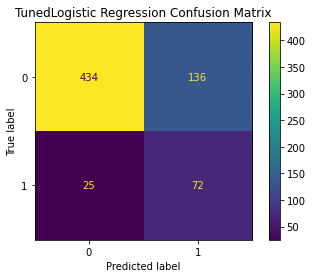

In [97]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax)

ax.set_title("TunedLogistic Regression Confusion Matrix")
plt.show()

In [98]:
TP = 72
FP = 136
TN = 434
FN = 25


Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_Score = 2 * (Precision * Recall) / (Precision + Recall)
print(f"Precision: {Precision:.3f}")
print(f"Recall: {Recall:.3f}")  
print(f"F1 Score: {F1_Score:.3f}")

Precision: 0.346
Recall: 0.742
F1 Score: 0.472


Interpretation:


F1 score is low since the precision score is low and the score of 0.472 , while recall is at 0.742 meaning it correctly identifies 74% of customers who actual churned. Having a low precison means it picks more clients as churned thus the company using its resources to deal with clients who were not churning. 

ROC AUC Score: 0.8151021884608429


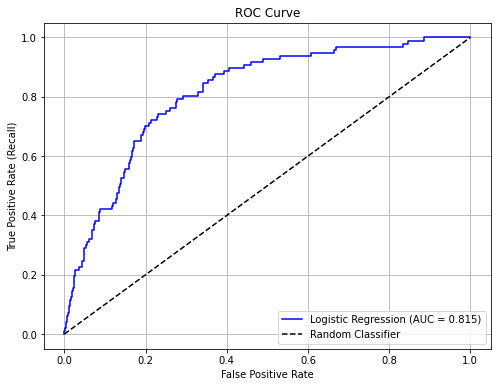

In [99]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Decision tree 

In [100]:
#instantiate our tree and balancing the imbalanced data
dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    class_weight="balanced",
    random_state=42
)  # here we are still balancing the data as the data for target has class heavily imbalanced

dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=20, random_state=42)

In [101]:
#Predict on the test data
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

#Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Decision Tree Performance:", accuracy_score(y_test, y_pred_dt))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       570
           1       0.65      0.73      0.69        97

    accuracy                           0.90       667
   macro avg       0.80      0.83      0.82       667
weighted avg       0.91      0.90      0.91       667

Decision Tree Performance: 0.904047976011994


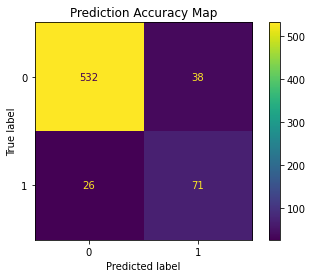

In [108]:
cm = confusion_matrix(y_test, y_pred_dt)

fig, ax = plt.subplots()

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax)

ax.set_title("Prediction Accuracy Map")
plt.show()

Interpretation

The weighting did improve recall for churners (0.73), meaning the model is catching more of the clients at risk of leaving.

Precision for churn (0.65) is still relatively low, so the model raises some false alarms — but in churn prediction, false positives are usually less costly than false negatives (better to flag a client who won’t leave than miss one who will).

The model is now more balanced: it doesn’t just favor the majority class (non-churn), but still struggles to achieve the same precision/recall levels for churn as for non-churn.




In [103]:
# Compare both models using ROC


lr_fpr, lr_tpr, i = roc_curve(y_test, y_pred_proba)
dt_fpr, dt_tpr, i = roc_curve(y_test, y_prob_dt)

lr_auc = auc(lr_fpr, lr_tpr)
dt_auc = auc(dt_fpr, dt_tpr)

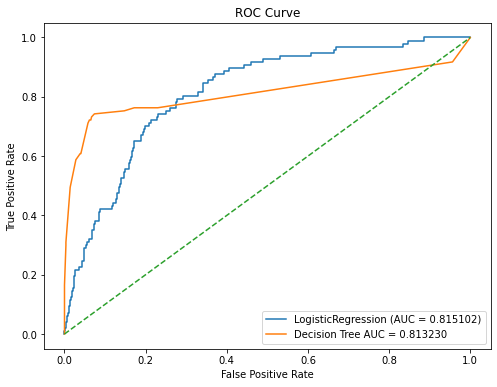

In [107]:
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'LogisticRegression (AUC = {lr_auc:2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree AUC = {dt_auc:2f}')
plt.plot([0,1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Conclusion

Both the logistic regregression and the decision tree model achieved an AUC of 0.81, indicating good discrimination ability.The models can coreectly distinguish between a churned client and a non churned client , 81% of the time thus a can be used to support customer retention strategy.